In [1]:
import glob
import pandas as pd
import numpy as np
import scanpy as sc
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pathlib
import celltypist
from celltypist import models
params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 10,
    'font.family': "Arial",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 100
   }

tissue = 'SP'
mpl.rcParams.update(params)
sns.set_style("ticks")
sns.set_context(context='paper')
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0, "transparent": True}
mpl.rc('savefig', dpi=300)
output_dir='figures/QCandAnnotation/{}'.format(tissue)
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".png", ".svg"]
sc.settings.figdir = output_dir
sc.set_figure_params(format='pdf', transparent=True,)
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20) 
pd.set_option('display.width', 100)
%load_ext autoreload
%autoreload 2

In [2]:
%run ../_helper.py

In [3]:
vdj_df = pd.read_table("/home/michaelswift/repos/shared_data/tbd_share/vdj_integrated_with_flags.tsv.gz", index_col=0)

<ipython-input-3-e00e7bdcef57>:1: DtypeWarning: Columns (2,3,4,5,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,46,54,56,58,59,60,63,73,74,75,76,77,78,79,82,83,91) have mixed types. Specify dtype option on import or set low_memory=False.
  vdj_df = pd.read_table("/home/michaelswift/repos/shared_data/tbd_share/vdj_integrated_with_flags.tsv.gz", index_col=0)


In [4]:
def merge_vdj(adata, vdj_df):
    vdj_df = vdj_df.reset_index()
    # prepare merge
    vdj_df['cb_suid'] = vdj_df['cb'] + "_" + vdj_df['sample_uid']
    # remove duplicates
    vdj_df = vdj_df[~vdj_df['cb_suid'].duplicated()]    
    obs_df = adata.obs
    obs_df['cb'] = pd.Series(obs_df.index).str.split('-', expand = True)[0].values
    obs_df['cb_suid'] = obs_df['cb'].astype(str) + "_" + obs_df['sample_uid'].astype(str)
    obs_df.set_index('cb_suid', inplace = True)
    vdj_df.set_index('cb_suid', inplace = True)

    # merge
    obs_df = pd.merge(obs_df, vdj_df, left_index=True, right_index=True, how = 'left', suffixes=[None, "_vdj"])
    adata.obs = obs_df
    return adata

In [5]:
data_path = "/home/michaelswift/repos/shared_data/pipeline_outs/"
for file in glob.glob(data_path+"*"):
    print(file)
    # do the routine:
    # load data
    if tissue in file:
        adata = sc.read_h5ad(file)
        adata = merge_vdj(adata, vdj_df)
        # remove IGH and IGL variable genes from highly variable genes for clustering analysis 
        adata.var.loc[adata.var.index.str.contains("IGHV|IGLV|IGKV|FOS|JUN|HSP|RPL"), 'highly_variable'] = False
        # ad hoc exclusion of weird samples
        adata = adata[adata.obs.sample_uid != 'TBd3_fresh_B200']
        adata = cluster(adata, batch_correct=False)
        filter_low_abundance_cell_groups = False
        cell_group = "predicted_labels"
        if filter_low_abundance_cell_groups:
            select = adata.obs[cell_group].value_counts() > (adata.obs.shape[0] / 1000)
            adata = adata[adata.obs[cell_group].isin(select[select == True].index)]
        

/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_LN.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_PB.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/swift_etal.h5ad
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_BM.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_subsampled.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/web_summary
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_SP.h5ad.gz
PCA-ing
drawing neighbor graph
UMAP-ing
leiden-ing


In [6]:
predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting=True)
adata = predictions.to_adata()
# not sure why this isn't added automatically
adata.uns['log1p'] = {"base":np.e}

🔬 Input data has 77303 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


In [7]:
filter_low_abundance_cell_groups = True
cell_group = "predicted_labels"
if filter_low_abundance_cell_groups:
    select = adata.obs[cell_group].value_counts() > (adata.obs.shape[0] / 1000)
    adata = adata[adata.obs[cell_group].isin(select[select == True].index)]
adata.obs['predicted_labels'].cat.remove_unused_categories(inplace=True)
adata.obs.loc[:, 'log_n_umis'] = np.log10(adata.obs.n_umis)

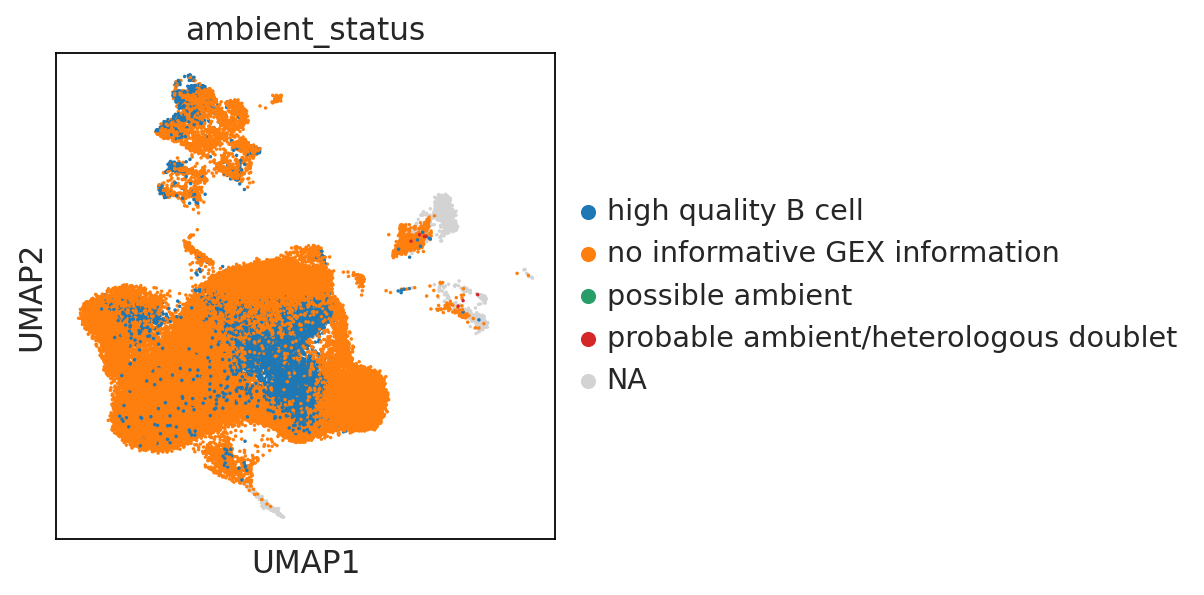

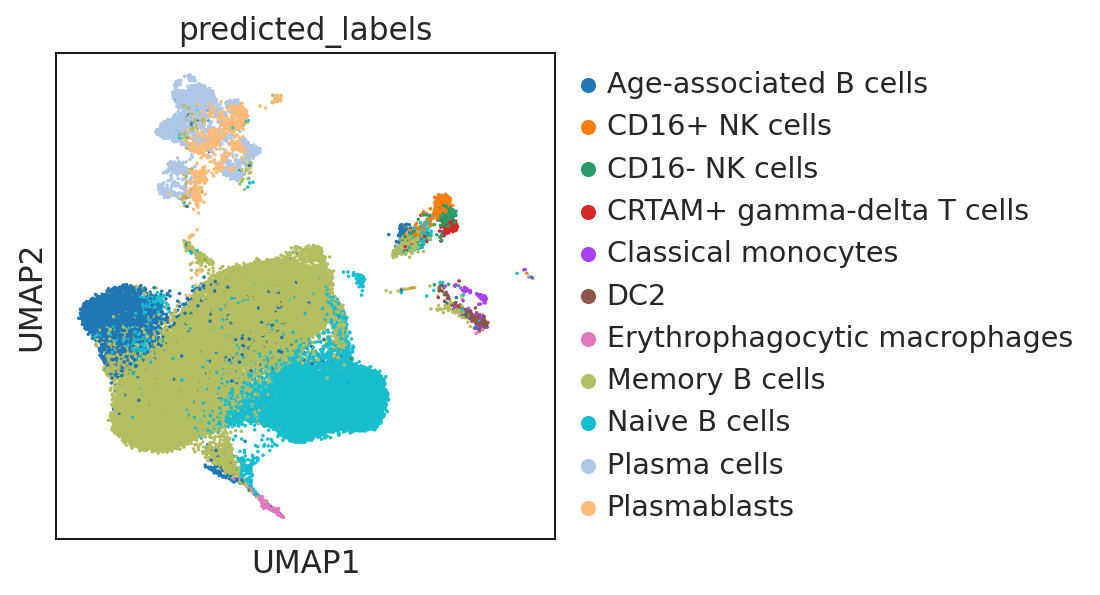

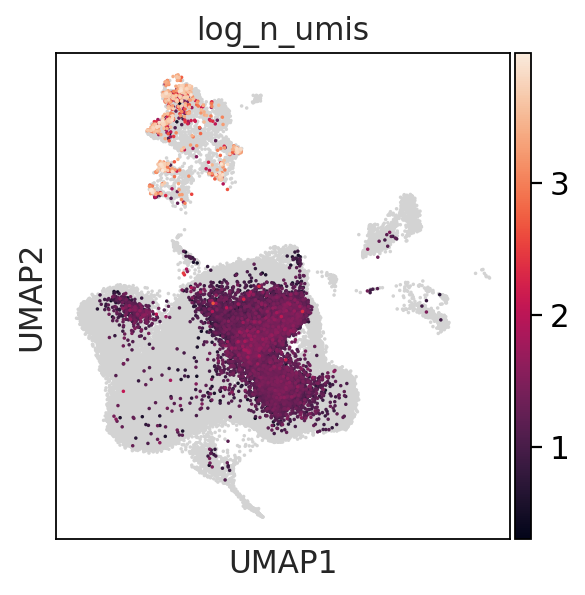

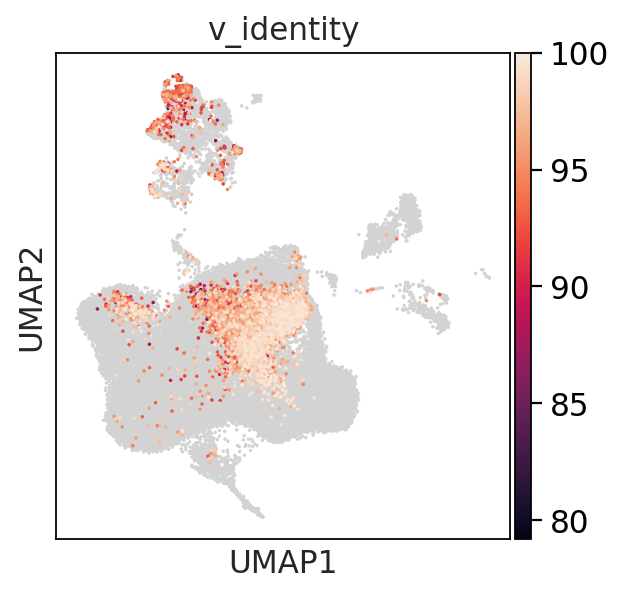

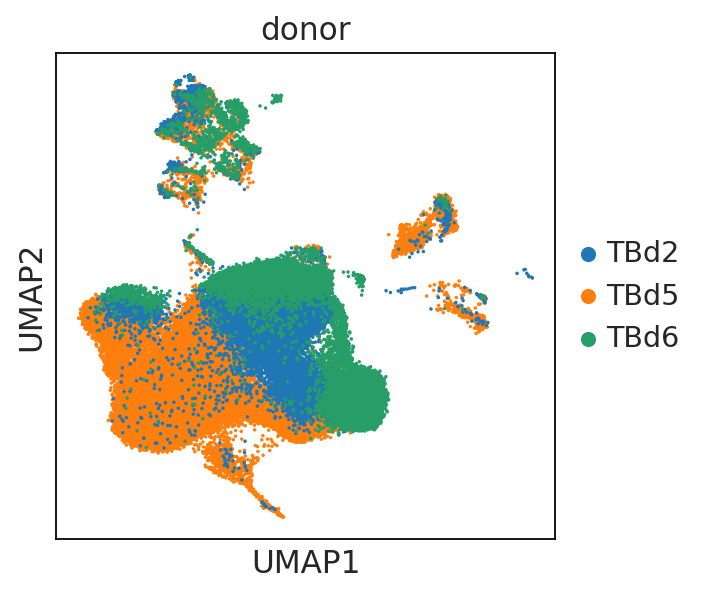

In [22]:
variables = ['ambient_status', 'predicted_labels', "log_n_umis", 'v_identity', 'donor']
for var in variables:
    sc.pl.umap(adata, color = var, size = 10, save = "{}_{}".format(var, tissue))

## umis by celltype

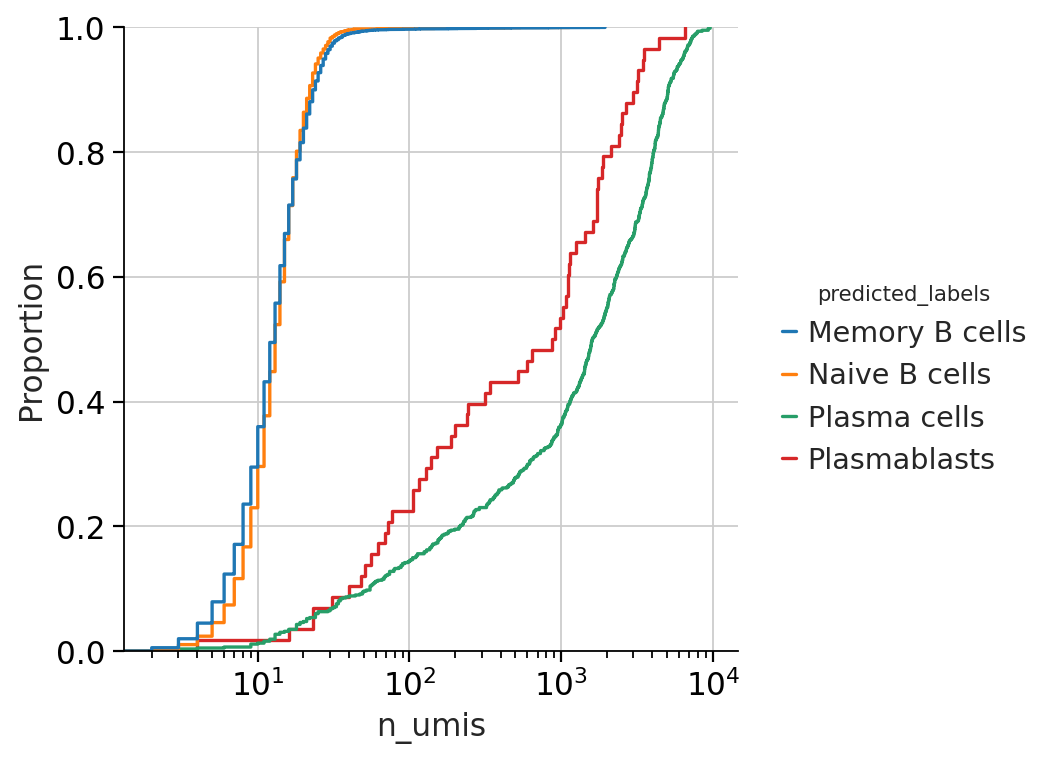

In [9]:
data = adata.obs[adata.obs.predicted_labels.str.contains("Naive B|Memory|Plasma")]
data.predicted_labels.cat.remove_unused_categories(inplace = True)
hue = 'predicted_labels'
kind = 'ecdf'
x = "n_umis"
g = sns.displot(data = data, x = x, kind = kind, log_scale=True, hue = hue)
save_figure(g.fig, "{}_n_umis_{}".format(x,kind,hue))

In [30]:
# Is the total counts coming from IgH locus related to detection in the amplicon sequencing

umis = adata.to_df(layer = 'umi_counts')

In [37]:
adata.obs['gex_igh_umis'] = umis[igh_genes].sum(axis = 1)

In [56]:
adata.obs.predicted_labels.value_counts()

Memory B cells                   48579
Naive B cells                    17005
Age-associated B cells            5505
Plasma cells                      2395
Plasmablasts                      1514
CD16+ NK cells                     433
CD16- NK cells                     220
CRTAM+ gamma-delta T cells         212
DC2                                179
Classical monocytes                135
Erythrophagocytic macrophages      127
Name: predicted_labels, dtype: int64

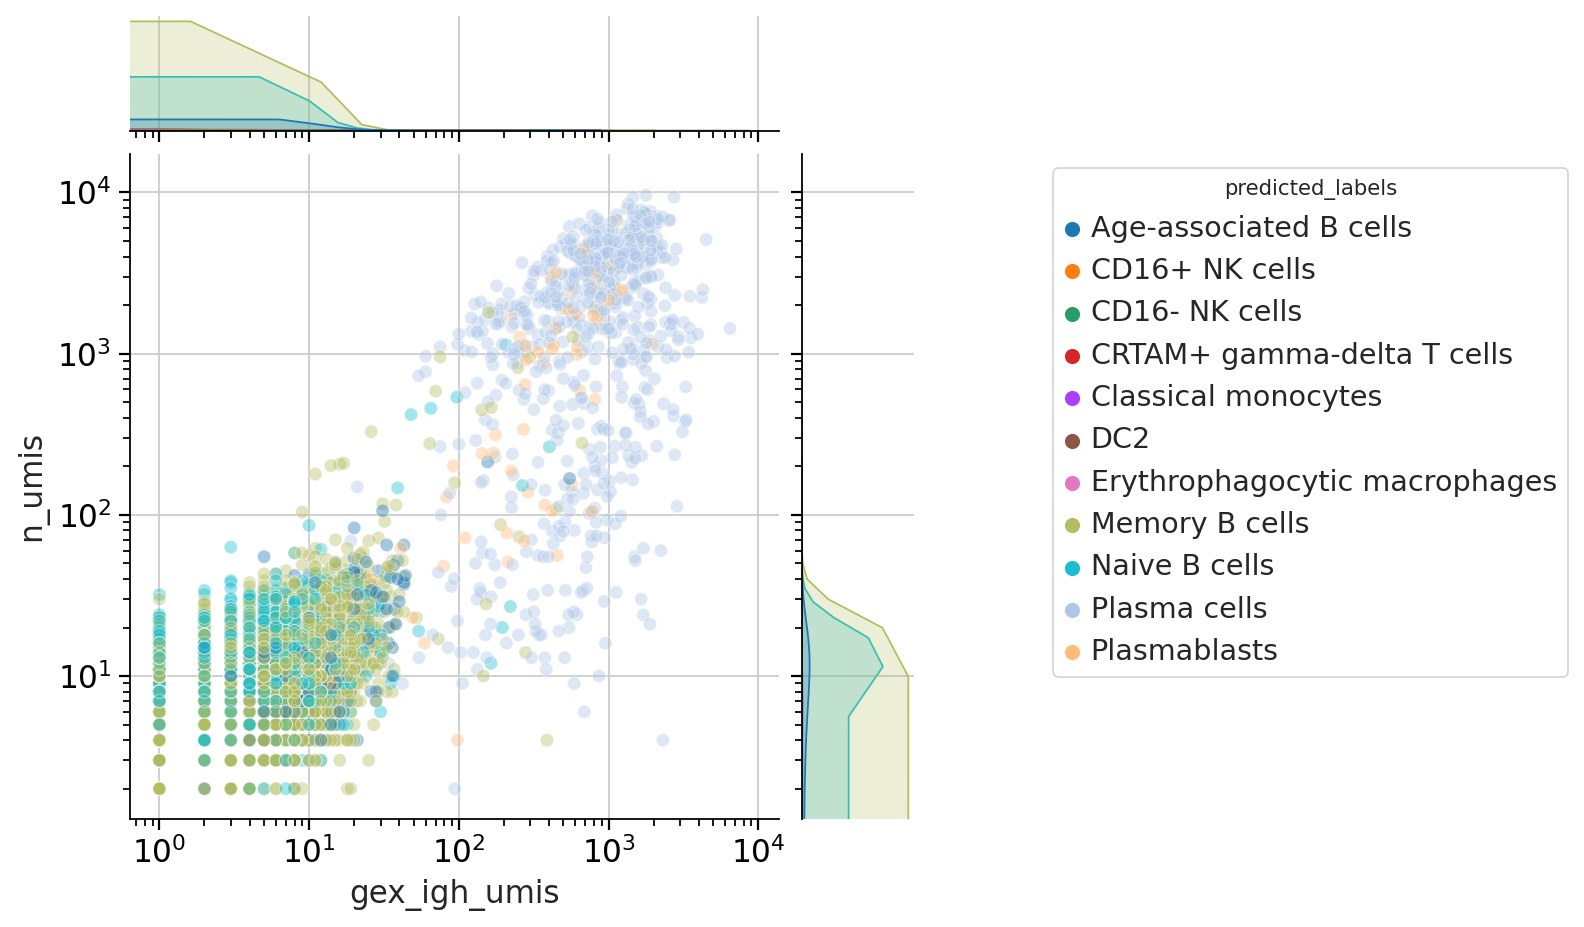

In [59]:
data = adata.obs
subsample = False
hue = "predicted_labels"
y = "n_umis"
x = "gex_igh_umis"
if subsample:
    data = data.sample(n=4000, replace=False)
g = sns.jointplot(data, x = x, y = y, lw = 2, hue = hue, alpha = 0.4)
sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(1.4, 1))
plt.xscale('log')
plt.yscale('log')
save_figure(g.fig, "{}_{}_{}_jointplot".format(y,x,hue))
        

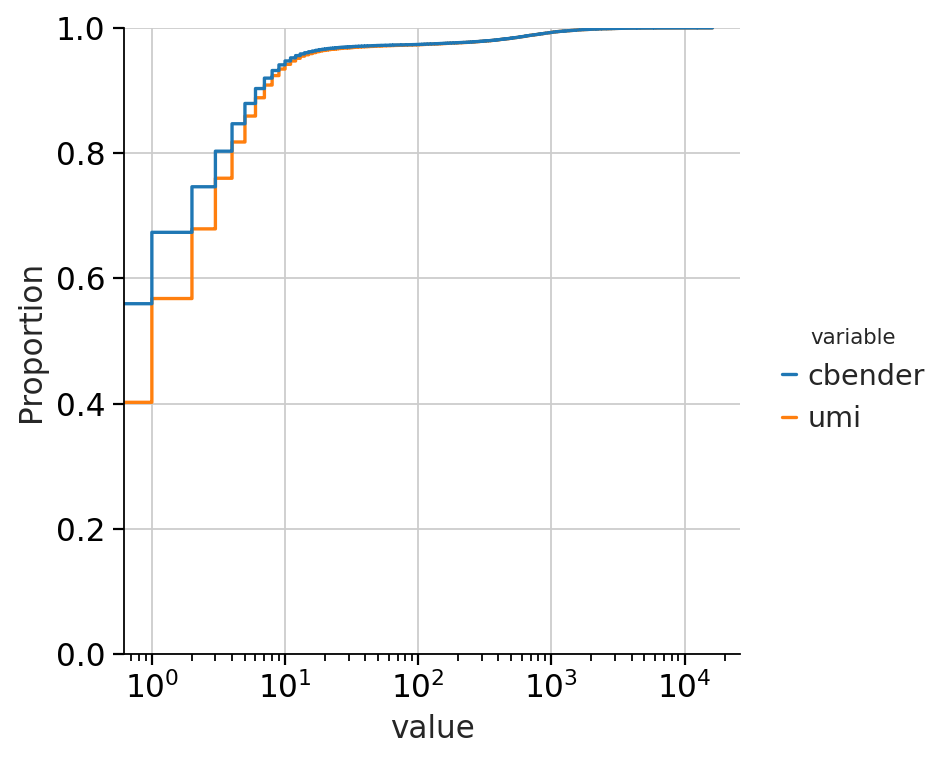

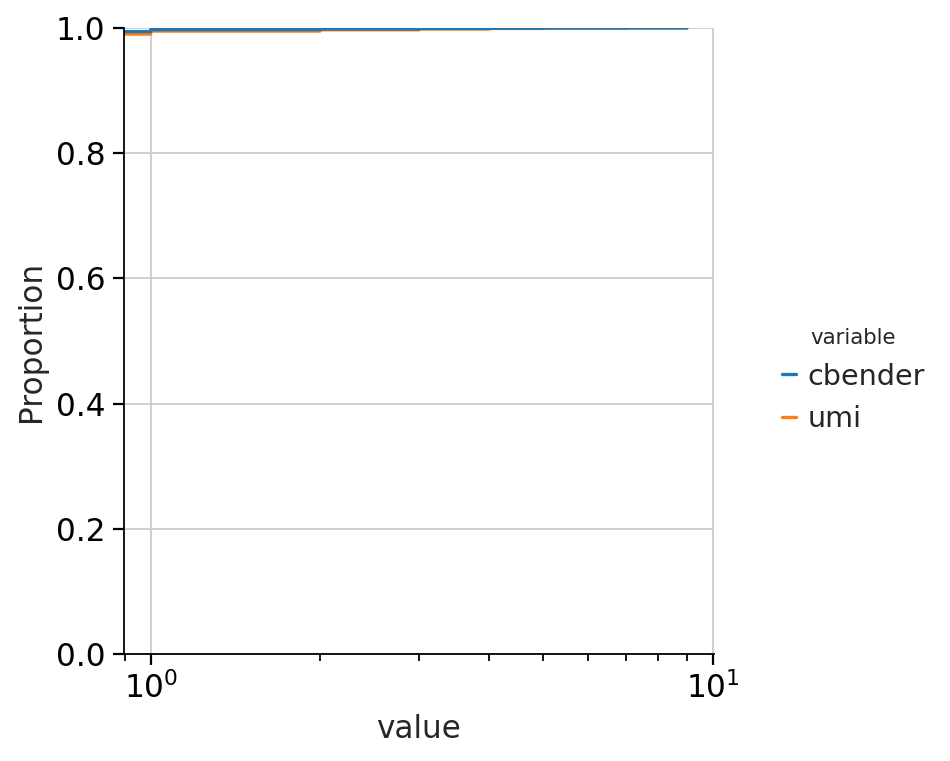

In [10]:
gene = "IGKC"

_umi = sc.get.obs_df(adata, keys = gene, layer='umi_counts')
_bg = sc.get.obs_df(adata, keys = gene, layer='background_removed')

data = pd.concat([_bg, _umi], axis=1)

data.columns = ['cbender', 'umi']

data = data.melt()

sns.displot(data, x = 'value', hue = 'variable', kind = 'ecdf', log_scale=True)

gene = "CD3E"

_umi = sc.get.obs_df(adata, keys = gene, layer='umi_counts')
_bg = sc.get.obs_df(adata, keys = gene, layer='background_removed')

data = pd.concat([_bg, _umi], axis=1)

data.columns = ['cbender', 'umi']

data = data.melt()

sns.displot(data, x = 'value', hue = 'variable', kind = 'ecdf', log_scale=True)

In [11]:
sc.tl.leiden(adata, key_added='{}_leiden'.format(tissue))

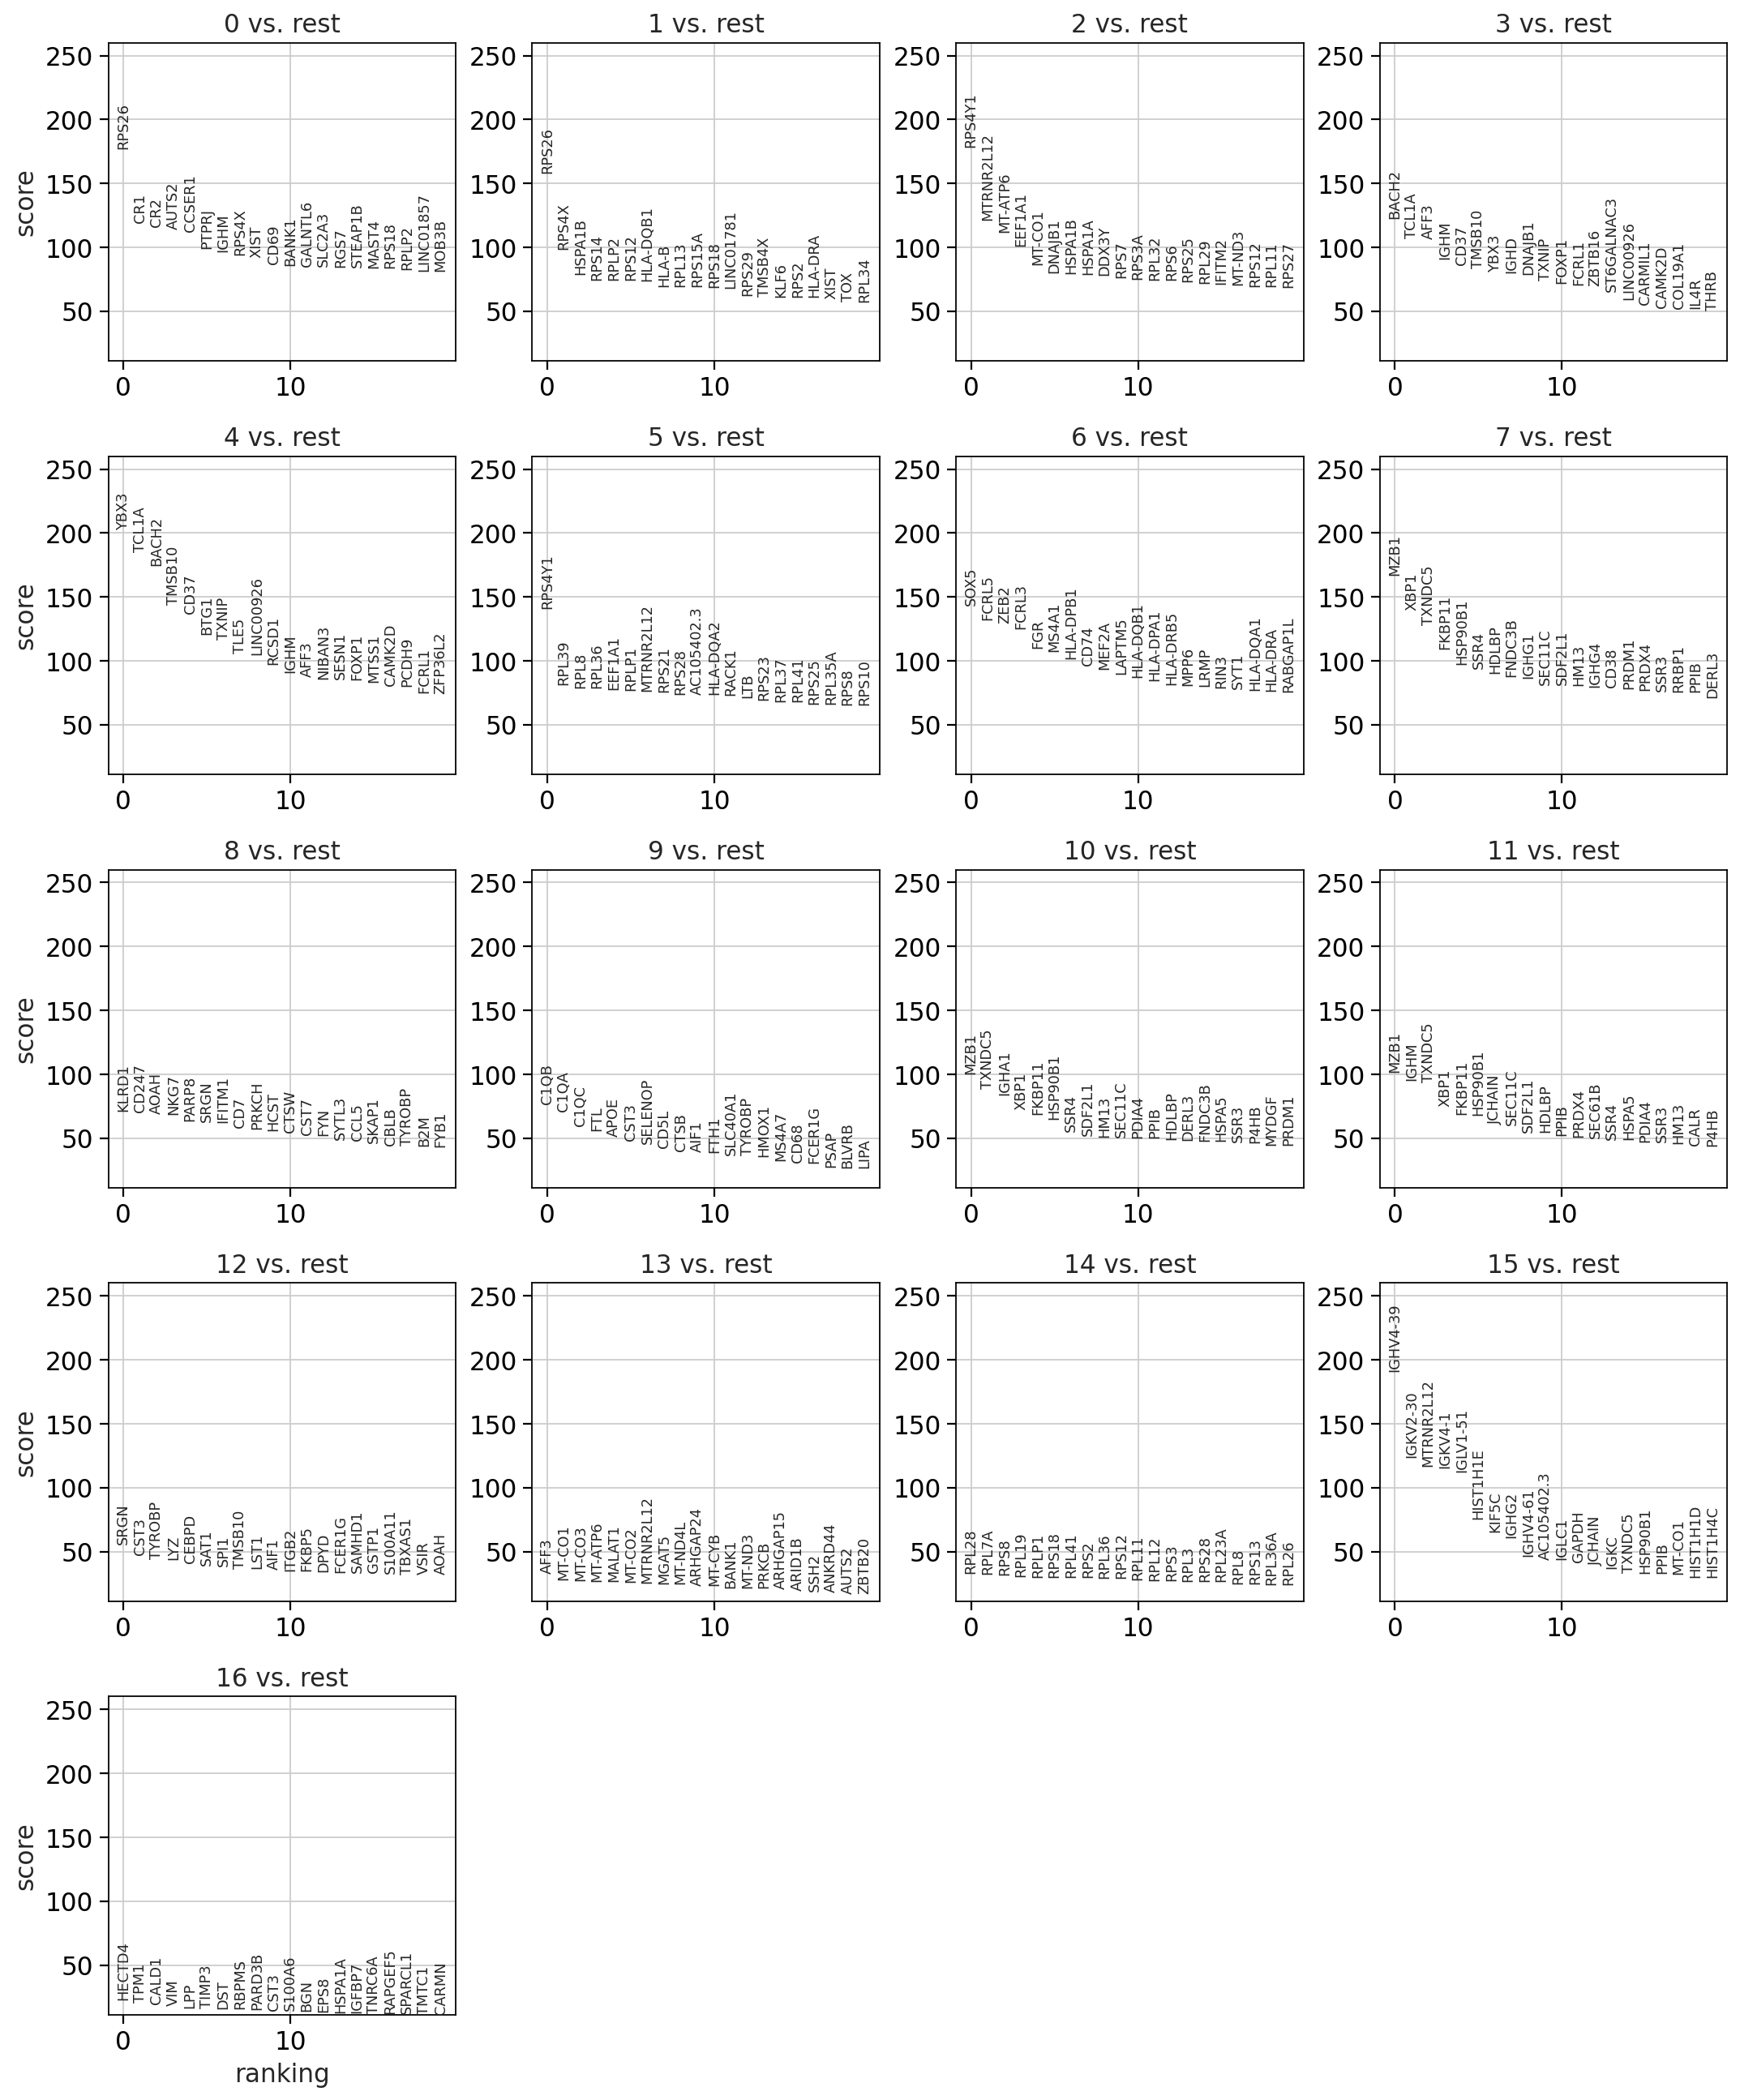

In [12]:
sc.tl.rank_genes_groups(adata, groupby='{}_leiden'.format(tissue))
sc.pl.rank_genes_groups(adata)

In [13]:
adata.obs['B_cell'] = adata.obs.predicted_labels.str.contains('B cell|Plasma|B-')

In [14]:
df = adata.obs[['sample_uid', 'majority_voting', 'n_genes', 'total_counts', 'total_counts_mt', '{}_leiden'.format(tissue), 'tissue', ]]

In [15]:
df.to_csv('{}_obs.tab'.format(tissue), sep = '\t')

## Filter Leiden groups which appear to be other celltypes

In [16]:
data = pd.DataFrame(adata.obs.groupby('sample_uid').B_cell.value_counts(normalize = True))

In [17]:
data.columns = ['fraction_b_cells']

In [18]:
data = data.reset_index()

In [19]:
data[data.B_cell]

,sample_uid,B_cell,fraction_b_cells
0,TBd2_frozen_SPa,True,0.989623
2,TBd2_frozen_SPb,True,0.992028
4,TBd5_frozen_SP,True,0.974843
6,TBd6_fresh_SPL,True,0.997860


In [20]:
file_name = "{}_bcell_fraction.tab".format(tissue)
data.to_csv(file_name, sep = '\t')

In [21]:
cell_group = 'leiden'
bcells = adata[adata.obs[cell_group].isin(['0', '2', '5', '6'])]
